This ection evaluates the Z vector required for Likelihood estimation of Medication Coverage and Cost & Quality

In this page, an evaluation of the suitability for drugs and specialties are conducted. An assessment of an empirical error and cognitive bias is required to understand how the latent variables behave against their counterparts which are:
- The Awareness of the drug from a Care prespective, and
- The Cognitive Bias of making a Drug Plan

### Examples:-

#### A Gaussian Process regression for finding the Empirical Error (Medication Coverage)

Drug Count | Prescribers | Supply | Claim | Logistic (Empirical) |
----------- | ----------- | ------ | ----- | ------------------- |
100 | 20 | 32992 | 987 | 0
120 | 23 | 23411 | 123 | 1

Empirical error is taken as the rate of change of the true measurement:

Empirical Error = | (y_true - y_pred) | / y_true
____________________________________

#### A Linear Support Vector Classification for finding the Cognitive Bias (Cost and Quality)

Drug Weight | Specialty Weight | Specialty Factor for Drugs | Drug Factor for Specialty |
----------- | ---------------- | -------------------------- | ----- |
123.4 | 7665.3 | 453.8 | 90.45

Cognitive Bias = Canberra Distance of the Observations

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import io, os, sys
sys.path.append(os.path.abspath(os.path.dirname('../code/')))
import pymysql
import CostFunction
from Database import Database, Partition
from sklearn import metrics
import seaborn
import pickle
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessRegressor
import pyGPs
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import ConstantKernel
from scipy.optimize import curve_fit
import math
from sklearn.preprocessing import minmax_scale

CostFunction.py Not in Command line Mode


In [3]:
partition = Partition('PA')
database = Database(partition)
costfunction = CostFunction.CostFunction(database)

In [ ]:
# Plot of categorical variables
empirical_data_sql = """
SELECT pa_spl_drug_shared_states.empirical_estimation,
pa_state_spl_drug_npi.specialty_description, pa_state_spl_drug_npi.drug_name, 
pa_state_spl_drug_npi.npi, pa_specialty_entropy.drug_count, swd.prescribers, 
pa_state_spl_drug_npi.total_day_supply, pa_state_spl_drug_npi.total_claim_count
FROM pa_state_spl_drug_npi
INNER JOIN claim_aggregates.pa_specialty_entropy ON 
pa_specialty_entropy.specialty_description = pa_state_spl_drug_npi.specialty_description
INNER JOIN drug_aggregates.state_wise_drug_state swd
ON swd.drug_name = pa_state_spl_drug_npi.drug_name
AND swd.state = 'Pennsylvania'
INNER JOIN optimization_tables.pa_spl_drug_shared_states ON
pa_spl_drug_shared_states.specialty_description = pa_state_spl_drug_npi.specialty_description AND
pa_spl_drug_shared_states.drug_name = pa_state_spl_drug_npi.drug_name
INNER JOIN optimization_tables.pa_kmeans_y_pred_drug_weight
ON pa_kmeans_y_pred_drug_weight.npi = pa_state_spl_drug_npi.npi AND
pa_state_spl_drug_npi.specialty_description = pa_kmeans_y_pred_drug_weight.specialty_description AND
pa_state_spl_drug_npi.drug_name = pa_kmeans_y_pred_drug_weight.drug_name
WHERE swd.state = 'Pennsylvania' AND pa_state_spl_drug_npi.specialty_description = 'Physician Assistant'
"""

cursor = database.info_connection.cursor()
cursor.execute(empirical_data_sql)
gauss_array = np.array(cursor.fetchall())
cursor.close()

In [11]:
plot_df = pd.DataFrame(columns=['Specialty Description', 'Drug Name', 'Empirical Estimate'])
for item in gauss_array.tolist():
    plot_df = plot_df.append(dict(zip(['Specialty Description', 'Drug Name', 'Empirical Estimate'], 
                                    [item[1], item[2], item[0]])), ignore_index=True)

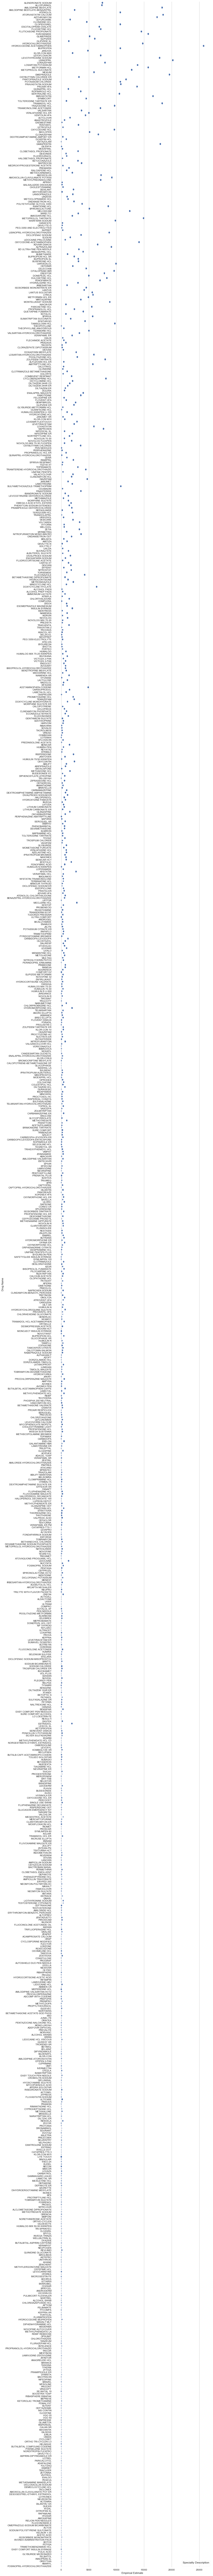

In [236]:
seaborn.set(style="whitegrid")
f, ax = plt.subplots()
seaborn.despine(bottom=True, left=True)
seaborn.stripplot(x="Empirical Estimate", y="Drug Name", hue="Specialty Description",
              data=plot_df, jitter=True,
              alpha=.25, zorder=1)
f.set_size_inches(12, 200)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[3:], labels[3:], title="Specialty Description",
          handletextpad=0, columnspacing=1,
          loc="lower right", ncol=3, frameon=True)

In [28]:
pickle.dump(gauss_array, open("pickle\\gauss_array.pkl", "wb"))

In [216]:
gauss_array = pickle.load(open("pickle\\gauss_array.pkl", "rb"))
y = np.array(gauss_array[:, 0], dtype=np.dtype(np.float64))
gauss_array = np.array(gauss_array[:, 4:], dtype=np.dtype(np.float64))

In [228]:
def gaussian(x, det, value, sigma):    
    return 25800 + np.exp(np.log(np.sum(np.exp(-0.5 * (1/sigma) * np.square(np.subtract(x, value))), 
                                axis=1)) + np.log(1 / (2 * math.pi)**0.5 * 1 / det))

covariance = np.cov(np.prod([gauss_array[:, 0], gauss_array[:, 2]], axis=0), 
                        np.prod([gauss_array[:, 1], gauss_array[:, 3]], axis=0))
mean_values = np.mean(gauss_array[:, 0:], axis=0)
array_x = np.transpose([gauss_array[:, 0] - mean_values[0], 
                        gauss_array[:, 1] - mean_values[1],
                       gauss_array[:, 2] - mean_values[2],
                       gauss_array[:, 3] - mean_values[3]])
x = array_x
theta_init = [np.sqrt(np.linalg.norm(gauss_array[:, 0:4], 2)), 0.05, covariance[0,1] / np.square(len(x))]
print(theta_init)
theta_vals, covar = 0, 0

[2134.145859129394, 0.05, 2058.4349325325393]


In [229]:
theta_vals, covar = curve_fit(gaussian, x, y, p0=theta_init)

print(theta_init)
print(theta_vals, covar)

[2134.145859129394, 0.05, 2058.4349325325393]
[  2.35607838e+03   4.22951827e-02   1.74023630e+03] [[  1.50201421e+17  -5.10513020e+10   1.46974593e+17]
 [ -5.10513020e+10   1.59451414e+13  -7.32970779e+13]
 [  1.46974593e+17  -7.32970779e+13   3.15930584e+18]]


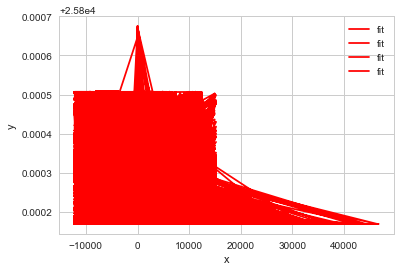

In [230]:
plt.plot(x, gaussian(x, *theta_vals), 'r-', label='fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [231]:
y_pred = gaussian(x, *theta_vals)
print("The Mean Squared Error: ", metrics.mean_squared_error(y, y_pred))
print("The Explained Variance Score: ", metrics.explained_variance_score(y, y_pred))
print("The R2 Score: ", metrics.r2_score(y, y_pred))

The Mean Squared Error:  380107700.754
The Explained Variance Score:  -2.71976308142e-09
The R2 Score:  -9.35018942398


In [3]:
cognitive_bias_sql = """
SELECT CONCAT(specialty_description, "_", drug_name) as y_value, specialty_description, drug_name, 
drug_weight, specialty_weight, specialty_factor_drug, CAST(drug_factor_specialty AS UNSIGNED) as drug_factor_specialty
FROM pa_factors;
"""

cursor = database.presc_connection.cursor()
cursor.execute(cognitive_bias_sql)
cognitive_bias = np.array(cursor.fetchall())
cursor.close()

In [5]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold

In [7]:
sgdc = SGDClassifier()
cog_x = np.array(cognitive_bias[:, 3:6], dtype=np.dtype(np.float64))
cog_y = cognitive_bias[:, 0]
kfold = KFold(n_splits=75, random_state=None, shuffle=True)
for train_index, test_index in kfold.split(cog_x):
    X_train, X_test = cog_x[train_index], cog_x[test_index]
    y_train, y_test = cog_y[train_index], cog_y[test_index]

In [8]:
sgdc.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [ ]:
test_score = sgdc.score(X_test, y_test)
train_score = sgdc.score(X_train, y_train)
score = sgdc.score(cog_x, cog_y)
cog_y_pred = sgdc.predict(cog_x)

In [15]:
print("Test data accuracy score: ", test_score)
print("Train data accuracy score: ", train_score)
print("The accuracy score of Stochastic Gradient Descent Classifier: ", score)

Test data accuracy score:  0.0
Train data accuracy score:  8.90432304884e-05
The accuracy score of Stochastic Gradient Descent Classifier:  8.78580214374e-05


The classification results obtained via Stochastic Gradient Classifier are:

| Specialty Description | Drug Name |
| -------------------- | ---------- |
| Family Practice   | BRINTELLIX             |
| Internal Medicine | TYPHIM VI              |
| Family Practice   | FLUTICASONE PROPIONATE |
| Internal Medicine | HYDROMORPHONE ER       |
| Internal Medicine | ADEFOVIR DIPIVOXIL     |

These may be useful when the KNearest Neighbors are evaluated.

The classification results obtained below are via the Linear Support Vector Machine Classification:

| Specialty Description | Drug Name |
| -------------------- | ---------- |
| Oral &  Maxillofacial Surgery      | PENICILLIN V POTASSIUM      |
| Sports Medicine                    | GABAPENTIN                  |
| Plastic and Reconstructive Surgery | TRAMADOL HCL-ACETAMINOPHEN  |
| Plastic and Reconstructive Surgery | NEOMYCIN-POLYMYXIN-DEXAMETH |
| Maxillofacial Surgery              | CHLORHEXIDINE GLUCONATE     |

**The Linear SVC Analysis has provided an algorithmic score of 0.00004 with the feature sets: Drug Weight, Specialty Weight, Specialty Factor Drug and Drug Factor Specialty.**

**The Stochastic Gradient Descent Classifier with feature set excluding Drug Factor Specialty compared with Linear SVC has also provided a low algorithmic score of 0.00008.**

**Probably the usage is wrong as the drug needs to be appended with the drug weight, and the specialty needs to be appended with the Specialty weight (for any evaluation that needs to be conducted) as Class Weights and then an analysis in further depth needs to be conducted.**

In [11]:
seaborn.set()

svc_df = pd.DataFrame(columns=['Drug Weight', 'Specialty Weight', 'Specialty Factor Drug', 'Drug Factor Specialty'])
for item in cognitive_bias.tolist():
    svc_df = svc_df.append(dict(zip(
        ['Drug Weight', 'Specialty Weight', 'Specialty Factor Drug', 'Drug Factor Specialty'], 
        np.array(item[3:7], dtype=np.dtype(np.float32))
    )), ignore_index=True)

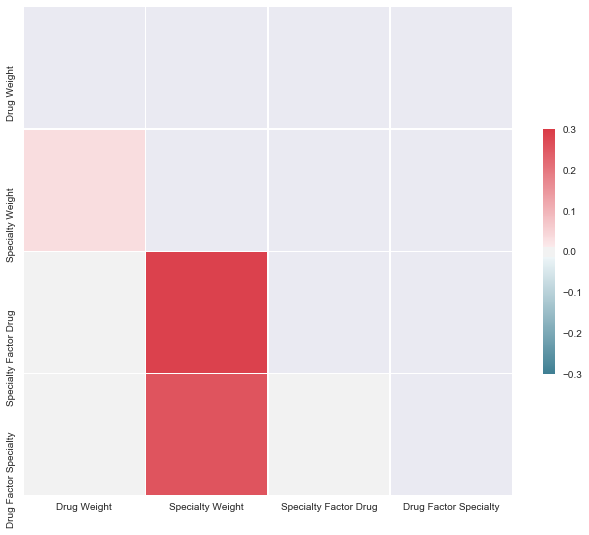

In [13]:
# svc_df_mod = pd.melt(svc_df, id_vars=['Drug Weight', 'Specialty Weight'], 
#                      var_name='Specialty Factor Drug', value_name='Drug Factor Specialty')
f, ax = plt.subplots(figsize=(11, 9))
corr = svc_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
# Write to database
idx = 0
cursor = database.opt_connection.cursor()
for item in cog_y_pred:
    try:
        database.opt_connection.begin()
        pred_values = item.split('_')
        cursor.execute("""INSERT INTO pa_cognitive_bias_estimate
        (specialty_description, drug_name, pred_specialty, pred_drug_name)
        VALUES
       ('{0}', '{1}', '{2}', '{3}')""".format(cognitive_bias[idx][1], cognitive_bias[idx][2], 
                        pred_values[0], pred_values[1]))
        if idx % 1000:
            database.opt_connection.commit()
        idx = idx + 1
    except Exception as e:
        database.opt_connection.rollback()
        raise e
cursor.close()

The relationship between Total Claim Count and Total Day Supply is unknown, so a mapping between them is necessary. Also, a mapping between Total Drug Cost and Total Claim Count is a must. Since likelihood is measured against Cost and Quality and Medication Coverage, a quadratic discriminant analysis must be conducted to investigate the predictability of the prescriptions. 

#### Feature sets required for Quadratic Discriminant Analysis between Claim Count and Total Day Supply

| Drug Weight | Drug Factor for Specialty | Total Day Supply | Total Claim Count |
| ------------ | ----------------------- | ---------------- | ------------------ |
| 100 | 200 | 213 | 97 |

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
discriminant_data_sql = """
SELECT drug_weight, drug_factor_specialty, total_claim_count, total_day_supply, pa_state_spl_drug_npi.specialty_description,
pa_state_spl_drug_npi.npi, pa_state_spl_drug_npi.drug_name
FROM pa_state_spl_drug_npi
INNER JOIN prescription_aggregates.pa_factors
ON pa_factors.specialty_description = pa_state_spl_drug_npi.specialty_description
AND pa_factors.drug_name = pa_state_spl_drug_npi.drug_name
"""
cursor = database.info_connection.cursor()
cursor.execute(discriminant_data_sql)
discriminant_data = np.array(cursor.fetchall())
cursor.close()

In [5]:
discriminant_analysis = LinearDiscriminantAnalysis()

In [10]:
discriminant_analysis.fit(np.array(discriminant_data[:, 1:4], dtype=np.dtype(np.float32)), 
                          np.array(discriminant_data[:, 5]))

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [16]:
cursor = database.info_connection.cursor()
cursor.execute("""
SELECT drug_weight, drug_factor_specialty, total_claim_count, total_day_supply, pa_state_spl_drug_npi.specialty_description,
pa_state_spl_drug_npi.npi, pa_state_spl_drug_npi.drug_name
FROM pa_state_spl_drug_npi
INNER JOIN prescription_aggregates.pa_factors
ON pa_factors.specialty_description = pa_state_spl_drug_npi.specialty_description
AND pa_factors.drug_name = pa_state_spl_drug_npi.drug_name
WHERE pa_factors.drug_name = 'GABAPENTIN'
""")
gabapentin_data = cursor.fetchall()
cursor.close()

In [18]:
gabapentin_data = np.array(gabapentin_data)

In [19]:
y_pred = discriminant_analysis.predict(np.array(gabapentin_data[:, 1:4], dtype=np.dtype(np.float32)))

**This prediction is a classification based on the drug factor for specialty, the claim count and the supply. Implying it will show allowable list of npi(s) for the drug 'GABAPENTIN'.**

In [28]:
quad_df = pd.DataFrame(columns=['Specialty', 'Drug', 'Total Claim Count','Total Day Supply', 'Predicted Specialty', 'Predicted Drug'])

spl_drug_sql = """
SELECT specialty_description, drug_name FROM pa_state_spl_drug_npi WHERE npi = '{0}'
"""

idx = 0
for item in gabapentin_data.tolist():
    cursor = database.info_connection.cursor()
    cursor.execute(spl_drug_sql.format(item[5]))
    query = cursor.fetchone()
    quad_df = quad_df.append(dict(zip(['Specialty', 'Drug', 'Total Claim Count', 'Total Day Supply', 'Predicted Specialty', 'Predicted Drug'], 
                         [item[4].__str__(), item[6].__str__(),
                         float(item[2]), float(item[3]), query[0], query[1]])), ignore_index=True)
    cursor.close()
    idx = idx + 1

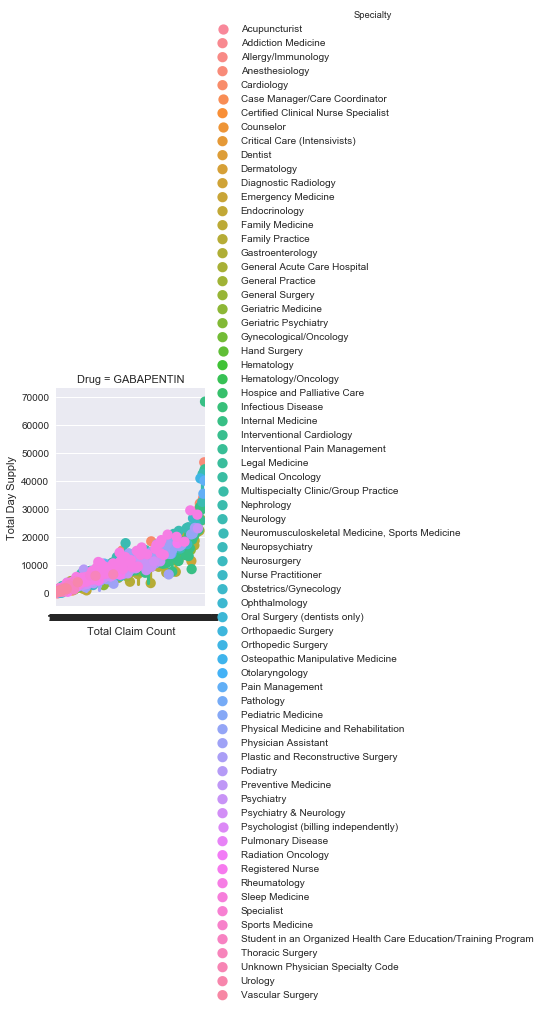

In [33]:
seaborn.set(style="darkgrid")
g = seaborn.factorplot(x="Total Claim Count", y="Total Day Supply", col="Drug", hue="Specialty", data=quad_df)

____________________________

#### MEDICATION COVERAGE

Suitability of the drug in terms of the beneficiary count. A suitable weight for the Drug Factor Specialty has been addressed in the report and is obtained from the table `table_summary`.

In [6]:
suitability_drug_factor_specialty = """
SELECT bene_count / total_claim_count FROM table_summary
WHERE specialty_description = 'Clinic/Center'
"""

cursor = database.presc_connection.cursor()
cursor.execute(suitability_drug_factor_specialty)
suitable_weight_bene = cursor.fetchone()
cursor.close()
print("A suitable weight for Drug Factor Specialty is: ", suitable_weight_bene)

A suitable weight for Drug Factor Specialty is:  (Decimal('0.0439'),)


__________________________

#### COST AND QUALITY

Suitability of the drug in terms of the standardised fill count. A suitable weight for the Specialty Factor Drug has been addressed in the report and is obtained from the table `state_wise_drug_state`.

In [8]:
suitability_spl_factor_drug = """SELECT (part_d_30_day_fills - part_d_claims) / part_d_30_day_fills 
FROM state_wise_drug_state
WHERE drug_name = 'FORTEO'"""

cursor = database.aggregate_connection.cursor()
cursor.execute(suitability_spl_factor_drug)
suitable_weight_fill = cursor.fetchone()
cursor.close()
print("A suitable weight for the fill count is: ", suitable_weight_fill)

A suitable weight for the fill count is:  (Decimal('0.0586'),)
